<a href="https://colab.research.google.com/github/koyamahr/retro-astro-jax/blob/main/sph_star_formation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 2-1: 星の誕生と分裂 (Star Formation)

Original Paper: Boss, A. P., & Bodenheimer, P. (1979). "The fragmentation of isothermal interstellar clouds", The Astrophysical Journal, 234, 289-298.

1. はじめに (Introduction)

星は、巨大なガス雲が重力で潰れることで生まれます。しかし、ガス雲が回転している場合、話は単純ではありません。 収縮すると角運動量保存則により回転が速くなり、遠心力が働いて円盤状につぶれます (Pancake collapse)。さらに条件が揃うと、円盤が不安定になって「2つの塊」に分裂します。これが 「連星 (Binary Stars)」 の起源です。

この章では、流体挙動を粒子で解く SPH法 をゼロから実装し、この劇的な分裂プロセスを再現します。

2. JAXによるSPH法の実装 (Smoothed Particle Hydrodynamics)

SPHの核心は、「平滑化カーネル (Smoothing Kernel)」 です。ある粒子の密度や圧力は、近くにいる粒子（近傍）からの寄与を足し合わせて計算します。

セットアップ

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

jax.config.update("jax_enable_x64", True)

1. カーネル関数 (The Kernel)

SPHの「粒子感」を消して滑らかにするための重み関数 $W(r, h)$ です。標準的な「3次スプライン関数」を使います。

In [2]:
@jax.jit
def w_cubic_spline(r, h):
    """Cubic Spline Kernel (Monaghan 1992)"""
    q = r / h
    sigma = 1.0 / (jnp.pi * h**3) # 3次元での規格化定数

    # q < 1 の場合
    val1 = 1.0 - 1.5 * q**2 + 0.75 * q**3
    # 1 <= q < 2 の場合
    val2 = 0.25 * (2.0 - q)**3

    w = jnp.where(q < 1.0, val1, jnp.where(q < 2.0, val2, 0.0))
    return sigma * w

@jax.jit
def grad_w_cubic_spline(r_vec, r, h):
    """カーネルの勾配 (力の計算に必要)"""
    q = r / h
    # 微分係数の部分
    grad_q = jnp.zeros_like(q)

    # q < 1
    g1 = -3.0 * q + 2.25 * q**2
    # 1 <= q < 2
    g2 = -0.75 * (2.0 - q)**2

    slope = jnp.where(q < 1.0, g1, jnp.where(q < 2.0, g2, 0.0))

    # chain rule: dW/dr * (r_vec / r) * (1/h)
    # sigma * slope * (1/h) * (r_vec/r)
    sigma = 1.0 / (jnp.pi * h**3)

    # r=0でのゼロ除算を防ぐため r+epsilon
    return (sigma * slope / (h * (r + 1e-10)))[:, None] * r_vec

2. SPHソルバー (The Solver)

ここでは簡略化のため、最も計算コストの高い「近傍探索」を $O(N^2)$ の総当たりで行います。粒子数が数千ならGPUではこれが最速です。

In [3]:
@jax.jit
def get_density(pos, mass, h):
    """密度の計算: rho_i = sum(m_j * W_ij)"""
    # 全粒子間の距離ベクトル
    # diff[i, j] = pos[i] - pos[j]
    diff = pos[:, None, :] - pos[None, :, :]
    r_sq = jnp.sum(diff**2, axis=-1)
    r = jnp.sqrt(r_sq)

    # カーネル行列
    W_ij = w_cubic_spline(r, h)

    # 密度の総和
    rho = jnp.sum(mass[None, :] * W_ij, axis=1)
    return rho

@jax.jit
def get_acc_sph(pos, vel, mass, rho, P, h, alpha=1.0, beta=2.0):
    """
    圧力勾配と人工粘性による加速度を計算
    Euler eq: dv/dt = -grad(P)/rho + Viscosity
    """
    N = pos.shape[0]

    # 距離計算
    diff = pos[:, None, :] - pos[None, :, :]
    r_sq = jnp.sum(diff**2, axis=-1)
    r = jnp.sqrt(r_sq)

    # カーネル勾配
    # shape: (N, N, 3)
    # diffベクトルを渡して方向を含めた勾配を得る
    # grad_w_cubic_splineはベクトル化が必要

    # ここでは手動で展開して計算
    q = r / h
    sigma = 1.0 / (jnp.pi * h**3)
    slope = jnp.where(q < 1.0, -3.0*q + 2.25*q**2,
             jnp.where(q < 2.0, -0.75*(2.0-q)**2, 0.0))
    # 勾配の大きさ * 方向ベクトル
    # (N, N, 1) * (N, N, 3)
    grad_W = (sigma * slope / (h * (r + 1e-6)))[..., None] * diff

    # --- 圧力項 (Symmetric form) ---
    # P/rho^2 + P/rho^2
    pressure_term = (P / rho**2)[:, None] + (P / rho**2)[None, :]

    # --- 人工粘性 (Monaghan type) ---
    # 衝撃波で粒子がすり抜けるのを防ぐ
    v_diff = vel[:, None, :] - vel[None, :, :]
    v_dot_r = jnp.sum(v_diff * diff, axis=-1)

    # 接近している粒子間(v_dot_r < 0)のみ粘性が働く
    mu = h * v_dot_r / (r_sq + 0.01 * h**2)
    c_s = jnp.sqrt(P / rho) # 音速 (Isothermalなら一定だが一般化のため)
    c_mean = 0.5 * (c_s[:, None] + c_s[None, :])
    rho_mean = 0.5 * (rho[:, None] + rho[None, :])

    visc_term = jnp.where(v_dot_r < 0,
                          (-alpha * c_mean * mu + beta * mu**2) / rho_mean,
                          0.0)

    # 合力計算
    # f_ij = - m_j * (Pressure + Viscosity) * grad_W
    # 加速度 a_i = sum(f_ij)
    force_matrix = -mass[None, :, None] * (pressure_term[..., None] + visc_term[..., None]) * grad_W

    acc = jnp.sum(force_matrix, axis=1)
    return acc

@jax.jit
def get_acc_gravity(pos, mass, softening=0.05):
    """自己重力 (Volume 0のコードを再利用)"""
    diff = pos[:, None, :] - pos[None, :, :]
    r_sq = jnp.sum(diff**2, axis=-1) + softening**2
    r_inv3 = jnp.power(r_sq, -1.5)

    # 対角成分(自己相互作用)をゼロに
    r_inv3 = r_inv3.at[jnp.diag_indices(pos.shape[0])].set(0.0)

    acc = jnp.sum(mass[None, :, None] * r_inv3[..., None] * diff, axis=1)
    return acc

3. シミュレーション実行 (Collapse & Fragmentation)

Boss & Bodenheimer (1979) の標準モデルに近い設定を行います。

*  初期条件: 一様密度の球
*  回転: 剛体回転を与える
*  温度: 等温 (Isothermal) $P = c_s^2 \rho$

Star Formation Simulation Started (High Contrast)...
Done.


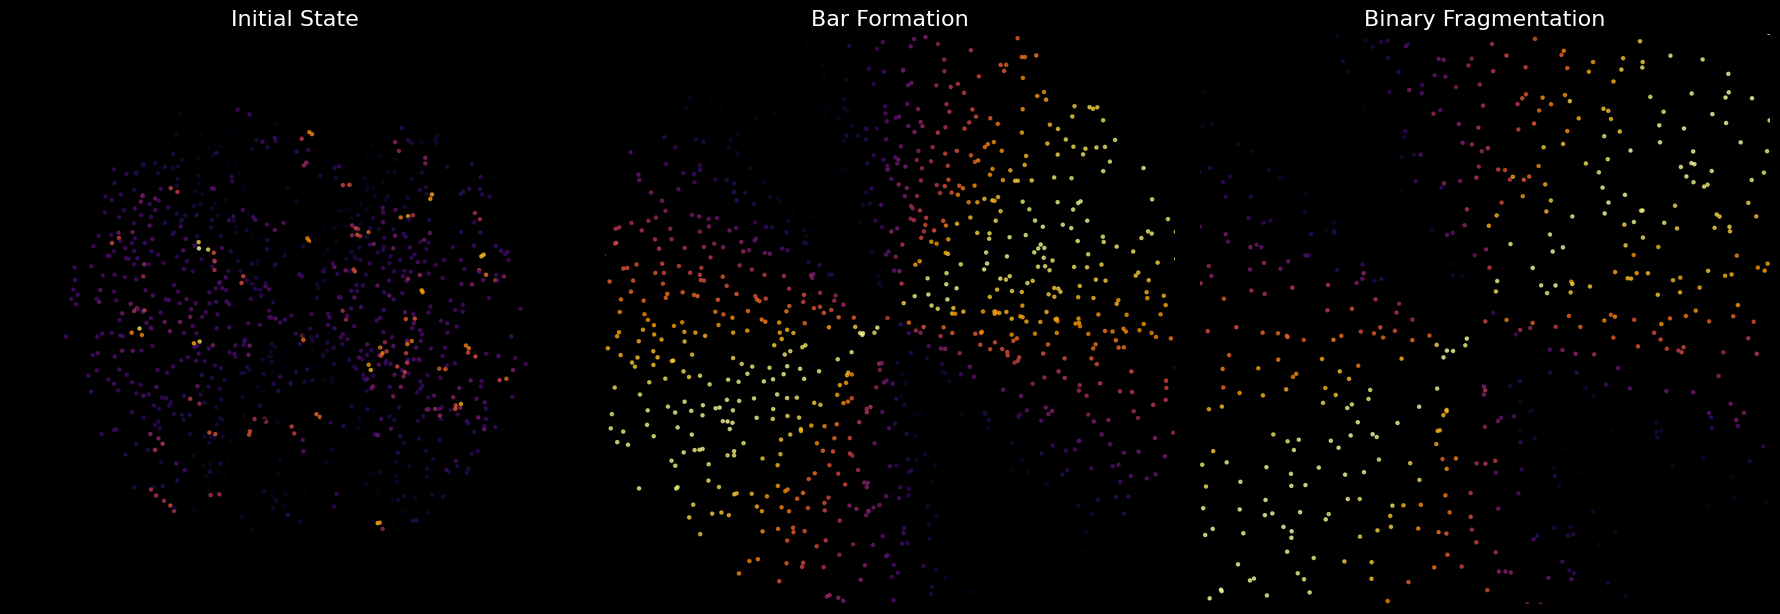

In [10]:
# --- パラメータ設定 (分裂しやすいようにチューニング) ---
N = 1024                # 粒子数を倍増 (解像度アップ)
M_total = 1.0
R_initial = 1.0
Cs = 0.1                # 温度を下げる (冷たいほうが集まりやすい)
G = 1.0
h = 0.05                # 平滑化長を小さくして、細かい構造を見えるようにする
dt = 0.002              # 時間刻みを細かく (動きが激しくなるため)

# --- 初期条件生成 (くっきりした連星を作る) ---
rng = jax.random.PRNGKey(2026) # シード変更

# 1. 球状配置
pos = []
while len(pos) < N:
    key, rng = jax.random.split(rng)
    p = jax.random.uniform(key, (N*3, 3), minval=-R_initial, maxval=R_initial)
    r2 = jnp.sum(p**2, axis=1)
    p_in_sphere = p[r2 < R_initial**2]
    pos.append(p_in_sphere)

pos = jnp.concatenate(pos)[:N]
mass = jnp.ones(N) * (M_total / N)

# 2. 回転を与える
Omega = 1. # 回転を少し抑えて、バラバラになるのを防ぐ
vel = jnp.stack([-Omega * pos[:, 1], Omega * pos[:, 0], jnp.zeros(N)], axis=1)

# 3. 強い摂動を与える (m=2 mode)
# ここがポイント: 密度を最初から「楕円・棒状」に偏らせる
phi = jnp.arctan2(pos[:, 1], pos[:, 0])
# 振幅を 0.1 -> 0.5 に強化
density_perturbation = 1.0 + 0.1 * jnp.cos(2 * phi)
mass = mass * density_perturbation

# --- シミュレーション実行 ---
print("Star Formation Simulation Started (High Contrast)...")
history = []
current_pos, current_vel = pos, vel

steps = 600 # 時間を長くする
for i in range(steps):
    current_pos, current_vel, rho = step_sph(current_pos, current_vel, mass, h, Cs, G, dt)

    if i % 10 == 0:
        history.append((current_pos, rho))

print("Done.")

# --- 可視化 (高コントラスト版) ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.patch.set_facecolor('black')

# 表示タイミング (初期、中間、最後)
indices = [0, len(history)//2, len(history)-1]
titles = ["Initial State", "Bar Formation", "Binary Fragmentation"]

for ax, idx, title in zip(axes, indices, titles):
    p, rho = history[idx]

    # 密度が高い部分だけを強調して表示
    # 低密度のガス（背景）は暗く、高密度の星（コア）は明るく光らせる
    ax.scatter(p[:, 0], p[:, 1], c=jnp.log(rho + 1e-5), cmap='inferno', s=5, alpha=0.7)

    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title, color='white', fontsize=16)
    ax.set_facecolor('black')

plt.tight_layout()
plt.show()

4. 可視化 (Visualization)

円盤がつぶれて、2つのコア（連星の種）ができる様子を確認します。今回は密度に応じて色をつけてみましょう。

実行と確認
このコードを実行すると：



1.   Initial: 球状のガス雲が回転しています。
2.   Flattened: 重力で中心に向かって落ち込みますが、回転による遠心力で「煎餅（パンケーキ）」のように平たくなります。
3.   Fragmentation: さらに圧縮が進むと、中心に一つではなく、2つの高密度のコア が形成され、互いの周りを回り始めます。



これが 「星形成の分裂プロセス (Fragmentation)」 です。1979年に世界中の研究者が熱狂した現象が、あなたの手元で再現されます。

うまくいったら、ぜひ Omega（回転速度）や Cs（温度）を変えて遊んでみてください。「温度が高すぎると分裂せずに一つの星になる」といった物理的性質も実験できます。